In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read data
adultData = pd.read_csv("Adult_data/adult.data", header=None, delimiter=",",)
#Add custom columns
adultData.columns = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation", "Relationship", "Race","Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

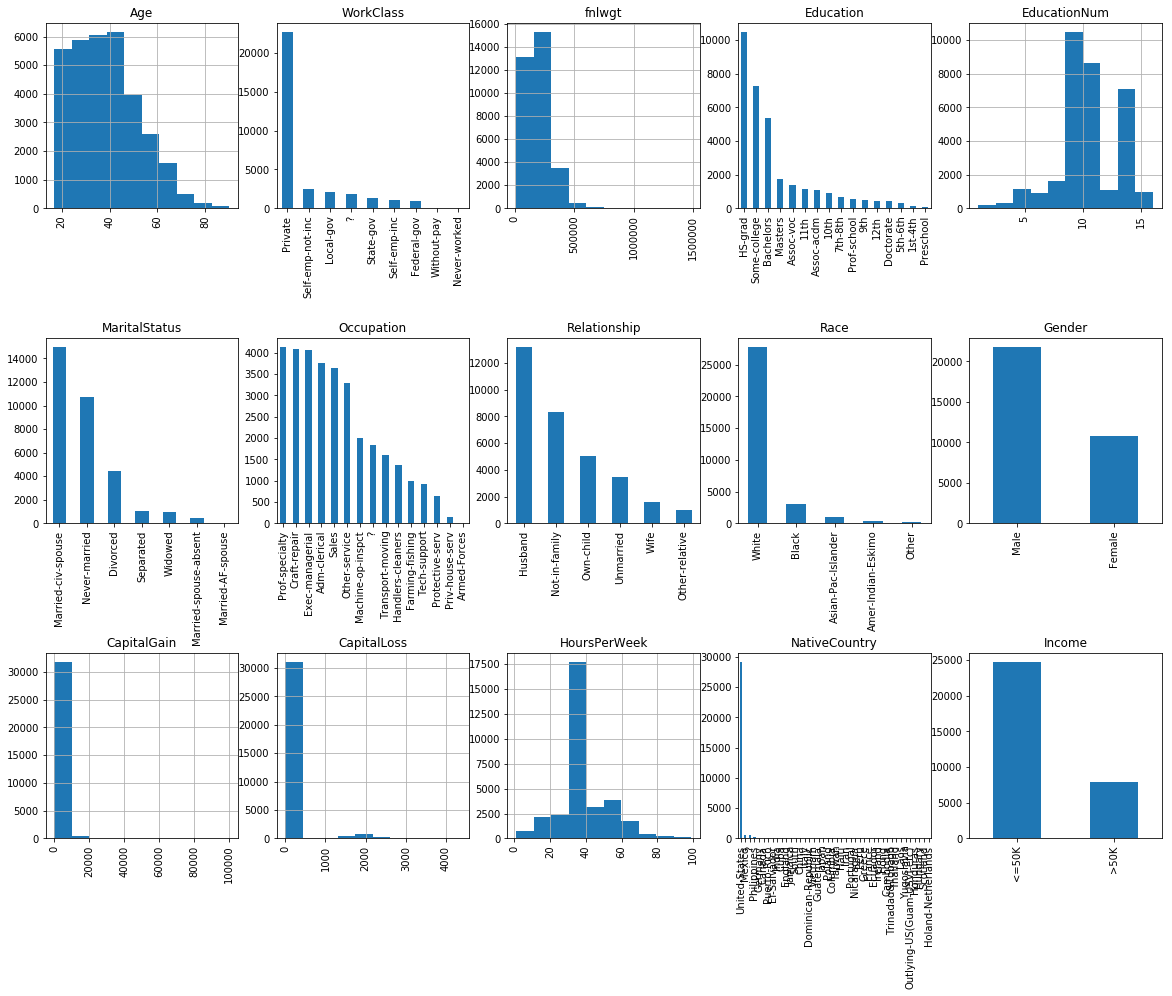

In [3]:
#Plotting the distribution of each feature

fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(adultData.shape[1]) / cols)
for i, column in enumerate(adultData.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if adultData.dtypes[column] == np.object:
        adultData[column].value_counts().plot(kind="bar", axes=ax)
    else:
        adultData[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)



The distribution of each feature is explored with the help of bar plots. Since each feature is individually  visualized, Line mark and position/length channel seems to be appropriate and easy to interpret. From the visualizations, it seems that the data is mainly concerned with USA, male, white people with an average working hours of 40 a week. The Capital gain and loss doesn't give us much information as most of its values are 0.

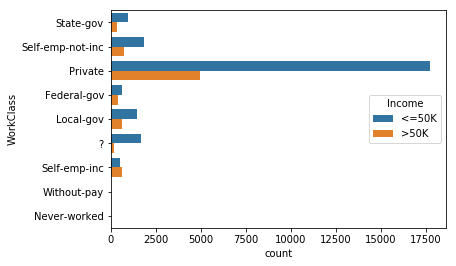

In [4]:
sns.countplot(y='WorkClass', hue='Income', data = adultData)

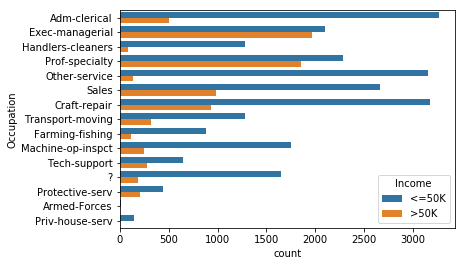

In [5]:
sns.countplot(y='Occupation', hue='Income', data = adultData)

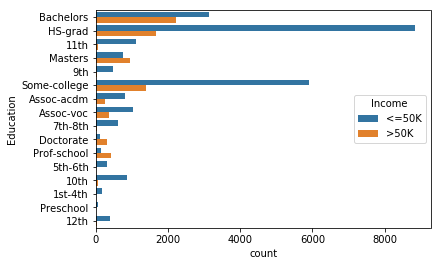

In [6]:
sns.countplot(y='Education', hue='Income', data = adultData)

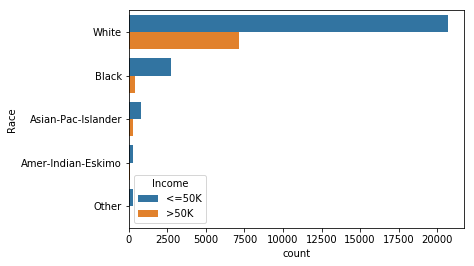

In [7]:
sns.countplot(y='Race', hue='Income', data = adultData)

We know see how Workclass, Occupation, education and Race which are the categorical variables are distributed with respect to target variable Income. Line is the mark with position and color as the channel to represent the count and the Income respectively in the plots. The count of datapoints with income <50k is waay more then the other. If you are in a private workclass, be a exex-manager or a prof with a speciality, then you are more probable to earn >=50k.

In [8]:
#Convert the strings in the categorical variables into Labels using the LabelEncoder
encodedData = adultData.copy()
encoders = {}
for column in encodedData.columns:
    if encodedData.dtypes[column] == np.object:
        encoders[column] = LabelEncoder()
        encodedData[column] = encoders[column].fit_transform(encodedData[column])

#Convert target variable into integers
adultData["Income"] = adultData["Income"].map({ "<=50K": -1, ">50K": 1 })
y_all = adultData.Income.values
encodedData = adultData.copy()
encoders = {}
for column in encodedData.columns:
    if encodedData.dtypes[column] == np.object:
        encoders[column] = LabelEncoder()
        encodedData[column] = encoders[column].fit_transform(encodedData[column])

#GEt the additional columns with get_dummies which is siilar to One Hot Encoding
oneHotEncoded = pd.get_dummies(encodedData, columns=[
    "WorkClass", "Education", "MaritalStatus", "Occupation", "Relationship",
    "Race", "Gender", "NativeCountry",
])


oneHotEncoded.drop("Income", axis=1, inplace=True,)

#Split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(
    oneHotEncoded, y_all, test_size=0.20, stratify=y_all,)




In [9]:
#Scale the features which have continous features

scaler = StandardScaler()
num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.int64))]
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [17]:
#Grid search over K (1-10) and p (l1 or l2 distance) and 10 fold CV. 

scores_p2 = []
best_score = 0
best_k = 0
best_p = 0
for k in range(1,11):
    for penalty in range(1,3):
        neigh = KNeighborsClassifier(n_neighbors=k, p=penalty)
        scores = cross_val_score(neigh, X_train, y_train, cv=10, scoring='f1')
        if(penalty == 2):
             scores_p2.append(scores)
        if(scores.mean() > best_score):
            best_score = scores.mean()
            best_k = k
            best_p = penalty

In [19]:
#printing the best K and p value
print(best_k, best_p)

9


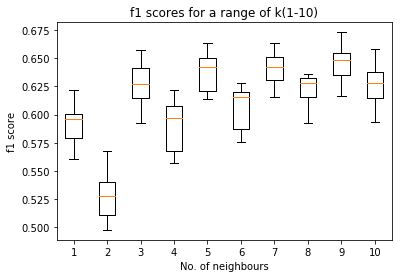

In [28]:

fig1, ax1 = plt.subplots()
ax1.set_title('f1 scores for a range of k(1-10)')
ax1.boxplot(scores_p2)
plt.xlabel('No. of neighbours')
plt.ylabel('f1 score')
plt.show()

Showcasing the performance of the model with a fixed p(l2 distance) and K rannging from 1 to 10. I've used a box plot the see the distributions of f1 score depending on the number of neighbours. The boxes are the marks and the position and area are the channels showing the mean f1 score and also the range of the f1 score distribution for a particular value of K. 
The mean f1 score is the max for k=9.

In [25]:
model = KNeighborsClassifier(n_neighbors=9,p=2)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
f1_score(y_pred=y_pred,y_true=y_test)

0.64157228514323783